# Querying MusicBrainz database

## Abstract

This project aims to examine various ways of querying the MusicBrainz database. Throughout the project we will demonstrate two main methods of distributed computing for big data to extract, load, and query the database. The first method will be extracting tables and loading them to BigQuery, this will be done through two approaches; one is extracting tables directly to big query and the other approach is using dataflow for loading, transforming and cleaning of the data. For the two approaches we will use sql query syntax and we will also do Partintioning. The second method will be uploading tables to hadoop, then loading and cleaning them using pyspark sql and using Graph data frames to perform motif queries. 

BigQuery allows us to run sql queries on the tables to obtain results in a few seconds. Also partitioning of tables with respect to certain columns allows us to cut the computation time even further, as the amount of data being processed decreases. In graphframes queries, the queries are implemented through a  Dataproc cluster and different number of worker nodes was used to evaluate the performance of the distributed computing system. It is shown that increasing the number of worker nodes has a positive impact on the computation speed of the motif queries.  

## Table of Contents

I. Introduction

II. Database

  * i) Description
  * ii) Setup

Main Content
    
III. BigQuery Approach

   *   i. Export, transform, and load into BigQuery
   *   ii. Partitioning
   *   iii. Dataflow BigQuery Approach

IV. HDFS Approach
  *   i. GraphFrames
  *   ii. Comparison of clusters performance

V. Conclusion




      


## I. Introduction

MusicBrainz is a community-maintained open source encyclopedia of music information. The Database is built on the PostgreSQL relational database engine and contains all of MusicBrainz music metadata; it includes information about artists, release groups, releases, recordings, works, and labels, as well as the many relationships between them. We will set up a replica of the database using google cloud dataproc cluster and extract the relevant tables from it. We will load the data then denormalize it in Bigquery to perform queries on it. 

The first approach uses BigQuery to load and transform the data. It is used to perform a one-time load of a small amount of data into BigQuery for analysis. In this approach we will also explore partitioning, which allows us to divide one table in different partitions according to a certain column, which makes it easier to manage and query the data, and allows for controlling costs by reducing the number of bytes read by a query. The other approach is using Dataflow; we use a pipeline to load the data, join the tables and do table mappings and it allows us to load a larger amount of data and load it automatically. 

Lastly, we will perform motif queries using graph data processing in Spark using the package GraphFrames which provides both the functionality of GraphX and extended functionality taking advantage of Spark DataFrames like motif finding, DataFrame-based serialization, and highly expressive graph queries.[1] We will use Apache HDFS for distributing file system data across different number of worker nodes to experiment the impact of distributed computing on the performance of the queries.


## II. Database

### i) Description

The MusicBrainz database is an open source encyclopedia about music, anyone can contribute to the database by adding information about their favorite artists and their works. MusicBrainz exists only to collect as much information about music and it does not discriminate or prefer one "type" of music over another; whether it is published or unpublished, popular or fringe, western or non-western, human or non-human. It contains information about around 1.6 million  artists, 2.5 million releases, and 22 million recordings. As mentioned above the database is built on the PostgreSQL relational database engine. It contains primary entities/tables; Area, Artist, Event, Label, Place, Recording, Release, Release group, Series, URL, and Work.
These are the main tables in the database, it also contains secondary entities and Schema. The Schema contains the SQL scripts that create the schema, alias tables that contain the alternate names for instances of the primary entities, and Relationship table structure that contains tables that explain the links between the primary tables.

We will be focusing on the Four main tables in the database; artist, recording, artist_credit_name, and release. The artist table contain information about the artist name, type; person, group, choir, etc., begining and ending date, gender, and area that they are identified with. The recording table links with the artist table through the artist_credit_name table to show all the recordings for each artist and their length, the release table represents the unique release of a product on a specific date with specific release information such as the country, label, barcode and packaging and it is also linked to the artist table.

Schema: **INSERT SCHEMA IMAGE**


### ii) Setup

In the coming steps we will show how to setup the database replica:

1. Create dataproc cluster on Google Cloud Platform

   In google SDK shell:
   
   #Create Bucket
   > gsutil mb gs://mira-bucket/
   #Initialize Cluster
   > gcloud init\
   gcloud config set dataproc/region europe-west2\
   gcloud beta dataproc clusters create st446-cluster 
  --properties=^#^spark:spark.jars.packages=graphframes:graphframes:0.5.0-spark2.1-s_2.11,com.databricks:spark-xml_2.11:0.4.1 
  --optional-components=ANACONDA,JUPYTER --image-version=1.3 --enable-component-gateway 
  --bucket mira-bucket --project st446-project-275401

2. Open SSH terminal
>Navigation menu > Compute Engine > VM instances > SSH

   Run the following commands

   install Python and psycopg2 
   >sudo apt install python python-pip python-psycopg2

   mbdata is a repo that contains collection of scripts for managing the database replica

   >sudo pip install -U mbdata

   Got API token by creating an account in MetaBrainz website then copied mbslave.conf file where I edited it with my API token and password

   >curl https://raw.githubusercontent.com/lalinsky/mbdata/master/mbslave.conf.default -o mbslave.conf

   Edit the file

   >vim mbslave.conf
   
  Set up the database

   >sudo apt install postgresql postgresql-contrib\
   sudo su - postgres\
   createuser musicbrainz\
   createdb -l C -E UTF-8 -T template0 -O musicbrainz musicbrainz\   
   createlang plpgsql musicbrainz\
   psql musicbrainz -c 'CREATE EXTENSION cube;'\
   psql musicbrainz -c 'CREATE EXTENSION earthdistance;'

   Prepare empty schemas for the MusicBrainz database and create the table structure
  >echo 'CREATE SCHEMA musicbrainz;' | mbslave psql -S\
  echo 'CREATE SCHEMA statistics;' | mbslave psql -S\
  echo 'CREATE SCHEMA cover_art_archive;' | mbslave psql -S\
  echo 'CREATE SCHEMA wikidocs;' | mbslave psql -S\
  echo 'CREATE SCHEMA documentation;' | mbslave psql -S

  >mbslave psql -f CreateTables.sql\
  mbslave psql -f statistics/CreateTables.sql\
  mbslave psql -f caa/CreateTables.sql\
  mbslave psql -f wikidocs/CreateTables.sql\
  mbslave psql -f documentation/CreateTables.sql

  Download dump files
  >wget http://ftp.musicbrainz.org/pub/musicbrainz/data/fullexport/20200506-001729/mbdump.tar.bz2 \
wget http://ftp.musicbrainz.org/pub/musicbrainz/data/fullexport/20200506-001729/mbdump-derived.tar.bz2 \
mbslave import mbdump.tar.bz2 mbdump-derived.tar.bz2

  Setup primary keys, indexes and views
  >mbslave psql -f CreatePrimaryKeys.sql\
mbslave psql -f statistics/CreatePrimaryKeys.sql\
mbslave psql -f caa/CreatePrimaryKeys.sql\
mbslave psql -f wikidocs/CreatePrimaryKeys.sql\
mbslave psql -f documentation/CreatePrimaryKeys.sql\
mbslave psql -f CreateIndexes.sql\
mbslave psql -f CreateSlaveIndexes.sql\
mbslave psql -f statistics/CreateIndexes.sql\
mbslave psql -f caa/CreateIndexes.sql\
mbslave psql -f CreateFunctions.sql\
mbslave psql -f CreateViews.sql

  Access the database
  >psql musicbrainz

  Use psql queries to get the relevant tables, convert them to JSON files and store them
  >\COPY (SELECT ROW_TO_JSON(r) FROM (SELECT * FROM musicbrainz.artist) r) TO artist.json; \
\COPY (SELECT ROW_TO_JSON(r) FROM (SELECT * FROM musicbrainz.recording) r) TO recording.json; \
\COPY (SELECT ROW_TO_JSON(r) FROM (SELECT * FROM musicbrainz.artist_credit_name) r) TO artist_credit_name.json; \
\COPY (SELECT ROW_TO_JSON(r) FROM (SELECT * FROM musicbrainz.artist_type) r) TO artist_type.json; \
\COPY (SELECT ROW_TO_JSON(r) FROM (SELECT * FROM musicbrainz.gender) r) TO artist_gender.json; \
\COPY (SELECT ROW_TO_JSON(r) FROM (SELECT * FROM musicbrainz.release) r) TO release.json; \
\COPY (SELECT ROW_TO_JSON(r) FROM (SELECT * FROM musicbrainz.area) r) TO artist_area.json;\
\q

  Delete extra characters
  >sed -i -e 's/\\\\/\\/g' artist.json \
sed -i -e 's/\\\\/\\/g' artist_credit_name.json\
sed -i -e 's/\\\\/\\/g' recording.json\
sed -i -e 's/\\\\/\\/g' artist_type.json\
sed -i -e 's/\\\\/\\/g' artist_gender.json\
sed -i -e 's/\\\\/\\/g' release.json\
sed -i -e 's/\\\\/\\/g' artist_area.json

  Copy all JSON files to the bucket
  >gsutil cp *.json gs://mira-bucket



## III. BigQuery Approach

### i. Export, Load, and Transform into BigQuery

In this approach we load the MusicBrainz tables into BigQuery individually, and then we join the loaded tables so that each row contains the data linkage we want. Then we store the joined results in a new BigQuery table. 

Loading tables into BigQuery
>Open BigQuery> Resources> st446-project-275401> Create Dataset> Dataset ID = musicbrainz> Create dataset

For each table we will repeat the same steps
>Create Table> Source > Google cloud Storage >mira-bucket/artist.json \
Table Name = artist

Under Schema, click on Edit as text, and then paste the table schema
I created four files for the schema of the Artist, Artist_credit, Recording, and Release tables.



### Mapping foreign key values to labels
In the Artist table there is type column and gender column that are coded, we use a query to map the key tables for both columns.

Create artist_table in BigQuery query editor:
>SELECT artist.id, artist.name as artist_name, artist_type.name as artist_type, artist_gender.name as artist_gender, 
artist.begin_date_year as artist_begin_year \
FROM musicbrainz.artist as artist \
INNER JOIN musicbrainz.artist_gender AS artist_gender \
ON artist.gender = artist_gender.id \
      INNER JOIN musicbrainz.artist_type AS artist_type \
          ON artist.type = artist_type.id

In [0]:
#imports to connect to BigQuery tables
import pandas as pd
import pandas_gbq
#to allow for large results
import google.cloud.bigquery.magics
google.cloud.bigquery.magics.context.use_bqstorage_api = True
%load_ext google.cloud.bigquery
#command to activate matplotlib
%matplotlib inline

In [0]:
%%bigquery
SELECT * FROM musicbrainz.artist_table 
LIMIT 10;

,id,artist_name,artist_type,artist_gender,artist_begin_year
0,1113629,Magnolia Crawford,Person,Other,1985
1,1439051,Dutch Rudder,Other,Other,2016
2,1127934,Elli Chandler,Person,Other,1994
3,1305549,Maud the moth,Character,Other,2010
4,1520419,Liam Jason,Person,Other,1956
5,984209,DJ Doktor Megatrip,Person,Other,1950
6,129869,Cri‐Crí,Character,Other,1934
7,1760983,MOISTBVRP,Other,Other,2018
8,1275402,Penny Andrews,Person,Other,1980
9,1963224,Cinemonia,Person,Not applicable,2012


In [0]:
#looking at the different types of artists
%%bigquery
SELECT DISTINCT artist_type FROM musicbrainz.artist_table   

,artist_type
0,Person
1,Other
2,Character
3,None
4,Orchestra
5,Choir
6,Group


In [0]:
#looking at different genders
%%bigquery
SELECT DISTINCT artist_gender FROM musicbrainz.artist_table   

,artist_gender
0,Male
1,Other
2,Female
3,Not applicable


In [0]:
%%bigquery
SELECT artist_name, artist_type, artist_gender FROM musicbrainz.artist_table 
WHERE artist_type IS NOT NULL
AND artist_gender IS NOT NULL
LIMIT 10;    

,artist_name,artist_type,artist_gender
0,Magnolia Crawford,Person,Other
1,Dutch Rudder,Other,Other
2,Elli Chandler,Person,Other
3,Maud the moth,Character,Other
4,Liam Jason,Person,Other
5,DJ Doktor Megatrip,Person,Other
6,Cri‐Crí,Character,Other
7,MOISTBVRP,Other,Other
8,Penny Andrews,Person,Other
9,Cinemonia,Person,Not applicable


Denormalize the artist_table with the recordings table to do more queries

artist_recording query in BigQuery query editor

>SELECT artist_table.artist_name, artist_table.artist_type, \
artist_table.artist_gender, artist_table.artist_begin_year, \
recording.name as recording_name, recording.length as recording_length, \
recording.video as video_recording \
FROM musicbrainz.artist_table as artist_table \
  INNER JOIN musicbrainz.artist_credit_name AS artist_credit_name \
ON artist_table.id = artist_credit_name.artist \
  INNER JOIN musicbrainz.recording AS recording \
ON artist_credit_name.artist_credit = recording.artist_credit 

Query complete (31.0 sec elapsed, 1.7 GB processed)

In [0]:
#lets look at the new table
%%bigquery
SELECT * FROM musicbrainz.artist_recording 
LIMIT 10;    

,artist_name,artist_type,artist_gender,begin_year,recording_name,recording_length,video_recording
0,Lula Wiles,Group,None,2014,Traveling On,219000.0,False
1,Mythos,Group,None,2010,Unleash the Kraken,292000.0,False
2,Downway,Group,None,1995,Roadkill,74000.0,False
3,Melos Quartett,Group,None,1965,"String Quartet in D major No. 6, D 74: IV. All...",294826.0,False
4,Akwid,Group,None,2000,No Hay Manera (Jason Roberts Remix),279733.0,False
5,Witchypoo,Group,None,1990,You Belong to Me,NaN,False
6,Sinfóníuhljómsveit Íslands,Orchestra,None,1950,Piano Concerto no. 2,1021640.0,False
7,Cellophane,Group,None,1995,I Crave You Gone,244866.0,False
8,Diapsiquir,Group,None,1996,180°,428133.0,False
9,Uncle Bonsai,Group,None,1981,Lois Lane,248666.0,False


In [0]:
#extract data where artist type is Orchestra
%%bigquery
SELECT artist_name, recording_name FROM musicbrainz.artist_recording 
WHERE artist_type = 'Orchestra'
LIMIT 10;    

,artist_name,recording_name
0,Bournemouth Symphony Orchestra,Carmina Burana: III. Cour D'amours (The court ...
1,Bournemouth Symphony Orchestra,"The Miraculous Mandarin, Sz. 73, op. 19: First..."
2,Orquesta Sinfónica de Radio Televisión Española,El amor brujo: II. En la cueva (La noche)
3,Royal Liverpool Philharmonic Orchestra,Symphonie Fantastique
4,Metropole Orkest,The Toy Trumpet
5,Sydney Symphony Orchestra,"Piano Concerto no. 3 in C major, op. 26: I. An..."
6,Nederlands Philharmonisch Orkest,"Symphony no. 9 in D minor, WAB 109 - II. Scher..."
7,London Festival Orchestra,Kol Nidre
8,London Festival Orchestra,Joseph! Joseph!
9,Boston Symphony Orchestra,"Lieutenant Kije, Symphonic Suite, op. 60: III...."


In [0]:
#Count the number of artists in each category
%%bigquery 
SELECT artist_type, COUNT(DISTINCT artist_name) AS artists_count FROM musicbrainz.artist_recording 
GROUP BY artist_type  

,artist_type,artists_count
0,Group,310100
1,Orchestra,5044
2,Person,404157
3,Choir,4537
4,None,311464
5,Character,6194
6,Other,1303


In [0]:
#count the number of recordings for each artist category
%%bigquery 
SELECT artist_type, COUNT(DISTINCT recording_name) AS recordings_count FROM musicbrainz.artist_recording 
GROUP BY artist_type  
ORDER BY recordings_count DESC;

,artist_type,recordings_count
0,Person,6348074
1,Group,4616418
2,None,1247511
3,Orchestra,378718
4,Other,222275
5,Choir,103020
6,Character,46547


Saving queries to tables to do visualizations

In [0]:
%%bigquery type_recordings_count
SELECT artist_type, COUNT(DISTINCT recording_name) AS recordings_count FROM musicbrainz.artist_recording 
GROUP BY artist_type 
ORDER BY recordings_count DESC

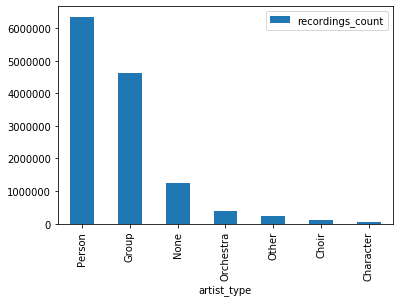

In [0]:
type_recordings_count.plot(kind='bar', x='artist_type', y='recordings_count');

In [0]:
%%bigquery 
SELECT artist_type, COUNT(DISTINCT recording_name) AS recordings_count, COUNT(DISTINCT artist_name) AS artists_count 
FROM musicbrainz.artist_recording 
GROUP BY artist_type  

,artist_type,recordings_count,artists_count
0,Person,6348074,404157
1,Group,4616418,310100
2,None,1247511,311464
3,Other,222275,1303
4,Orchestra,378718,5044
5,Choir,103020,4537
6,Character,46547,6194


In [0]:
%%bigquery rec_artist_type
SELECT artist_type, COUNT(DISTINCT recording_name) AS recordings_count, COUNT(DISTINCT artist_name) AS artists_count 
FROM musicbrainz.artist_recording 
GROUP BY artist_type 

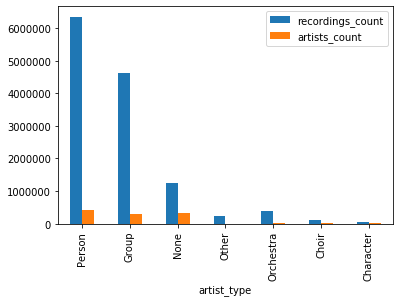

In [0]:
rec_artist_type.plot(kind='bar', x = 'artist_type');

In [0]:
#Showing recordings that are also videos
%%bigquery
SELECT DISTINCT artist_name, recording_name FROM musicbrainz.artist_recording 
WHERE video_recording = True
LIMIT 10;    

,artist_name,recording_name
0,Neeme Punder,A Chant of Bamboo
1,Chamath Sangeeth,Saba Adare - සැබෑ ආදරේ
2,Puhdys,Lust auf Abenteuer
3,Puhdys,Hit-Medley
4,Puhdys,Ewig leben
5,Genialistid,Unelaul
6,Motörhead,Killers
7,Motörhead,Love Me Like a Reptile
8,TWICE,TWICE “LIKEY” M/V TEASER 1
9,Jakko Jakszyk,A Scarcity of Miracles (short film)


In [0]:
#getting the artists who are males and have recordings length less than 1000
%%bigquery
SELECT DISTINCT artist_name, recording_length AS length 
FROM musicbrainz.artist_recording 
WHERE artist_gender='Male' and recording_length < 1000 
ORDER BY artist_name DESC 
LIMIT 10;           

,artist_name,length
0,大友良英,93
1,XLBaron,3
2,XLBaron,2
3,Willo Wonder,4
4,Uve Teschner,207
5,Toby Fox,565
6,The Polish Ambassador,571
7,TEDD,2
8,Stewart O'Nan,66
9,Stephen King,66


Query to denormalize Artist, Recordings, and Releases tables

artist_recording_release table
>SELECT artist.id, artist.gid as artist_gid,\
artist.name as artist_name, artist.area, artist.gender, artist.type,
      recording.name as recording_name, recording.length,
      recording.gid as recording_gid, recording.video, 
      release.name as release_name, release.release_group\
FROM musicbrainz.artist as artist\
 INNER JOIN musicbrainz.artist_credit_name AS artist_credit_name \
     ON artist.id = artist_credit_name.artist\
     INNER JOIN musicbrainz.release AS release\
     ON artist_credit_name.artist_credit = release.artist_credit \
     INNER JOIN musicbrainz.recording AS recording\
     ON artist_credit_name.artist_credit = recording.artist_credit 



In [0]:
#getting releases that contain the word shine
%%bigquery
SELECT artist_name, recording_name, release_name, release_group
FROM musicbrainz.artist_recording_release
WHERE release_name LIKE '%shine%'
LIMIT 10;

,artist_name,recording_name,release_name,release_group
0,Army of Lovers,Crucified 2013 (Soundfactory radio edit),Let the Sunshine In,313843
1,Army of Lovers,Crashing Down,Let the Sunshine In,313843
2,Army of Lovers,La Storia di O,Let the Sunshine In,313843
3,Army of Lovers,Ride the Bullet (David Ford & The Eg Orchestra...,Let the Sunshine In,313843
4,Rhonda Vincent,God Bless the Soldier,New Dreams and Sunshine,377362
5,Rhonda Vincent,Medals for Mother,New Dreams and Sunshine,377362
6,Bob Mould,You Say You,Sunshine Rock,2050786
7,The Sounds,Something to Die For (radio edit),Tony the Beat (the remixes: Rex the Dog & Tomm...,636366
8,松田聖子,九月の夕暮れ,Sunshine,1161055
9,松田聖子,春の風誘われて 〜Spring has come again〜,Sunshine,1161055


Query to denormalize Artists, Recordings, Releases, and Work tables in BigQuery editor:

new_table

>SELECT artist_table.artist_name, artist_table.artist_type, artist_table.artist_gender, 
artist_table.artist_begin_year, recording.name as recording_name, recording.length as recording_length,
recording.video as video_recording, release.name as release_name, work.name as work_name \
FROM musicbrainz.artist_table as artist_table  \
      INNER JOIN musicbrainz.artist_credit_name AS artist_credit_name\
  ON artist_table.id = artist_credit_name.artist \
      INNER JOIN musicbrainz.recording AS recording \
  ON artist_credit_name.artist_credit = recording.artist_credit \
  INNER JOIN musicbrainz.release AS release \
  ON artist_credit_name.artist_credit = release.artist_credit \
   INNER JOIN musicbrainz.work AS work \
  ON artist_table.id = work.id 

Query complete (45.2 sec elapsed, 1,016.1 MB processed)

In [0]:
%%bigquery
SELECT * FROM musicbrainz.new_table
LIMIT 10;    

,artist_name,artist_type,artist_gender,artist_begin_year,recording_name,recording_length,video_recording,release_name,work_name
0,Jinkx Monsoon,Person,Other,1988,Bring It! (Sweet Team club mix),469000,False,"Bring It! Remixes, Part 1",Sealand
1,UnMasked,Person,Not applicable,1997,Dusk,97164,False,Mask Makes Music,Shaker Loops: IV. A final shaking
2,UnMasked,Person,Not applicable,1997,Bad taste,234632,False,Assorted Tunes,Shaker Loops: IV. A final shaking
3,Jinkx Monsoon,Person,Other,1988,What About Debbie,233347,False,ReAnimated,Sealand
4,UnMasked,Person,Not applicable,1997,Seeking Warmth,194261,False,Something,Shaker Loops: IV. A final shaking
5,Jinkx Monsoon,Person,Other,1988,You've Really Got a Hold on Me,281920,False,ReAnimated,Sealand
6,Te Wānanga o Aotearoa,Other,Not applicable,1983,He Iti Kahurangi,172813,False,Te Ara Reo Māori: Wairere 1,Let It Burn
7,UnMasked,Person,Not applicable,1997,Just Humans,213473,False,Assorted Tunes,Shaker Loops: IV. A final shaking
8,Jinkx Monsoon,Person,Other,1988,Sugar Mama,239867,False,The Inevitable Album,Sealand
9,UnMasked,Person,Not applicable,1997,Glass,171000,False,Mask Makes Music 2,Shaker Loops: IV. A final shaking


### ii. Partitioning

A partitioned table is a special table that is divided into segments, called partitions, that make it easier to manage and query the data. By dividing a large table into smaller partitions, query performance can be improved, and costs can be controlled by reducing the number of bytes read by a query.

BigQuery allows partitioned tables based on a specific INTEGER column, with our choice of start, end, and interval values. Queries against integer range partitioned tables can specify predicate filters based on the partitioning column to reduce the amount of data scanned.

Integer range partitioned table can only be queried through Standard SQL. When an integer range partitioned table is queried, if there are filters on the integer partitioning column, the filters will be used to prune the partitions and reduce the query cost.

To demonstrate partitioning, we will create another table for Recordings (recording_part) that will be partitioned, we will do the partitioning by the **length** attribute:
1. Load the table into BigQuery as done previously
2. from Partition dropdown list choose **length** column
3. Add values for Start = 0, End = 265910000 and Interval = 100,000
4. Create Table

We will perform the two different queries in BigQuery editor on the two versions of the Recordings table and compare the differences in amount of data processed and computation time.

Query A:

*on recording table*
>SELECT  SUM(recording.length) FROM musicbrainz.recording as recording \
WHERE recording.length < 80000 

Query complete (1.0 sec elapsed, 150.8 MB processed) \
answer: 64185119930 

*on recording_part table*
>SELECT  SUM(recording_part.length) FROM musicbrainz.recording_part as recording_part \
WHERE recording_part.length < 80000

Query complete (0.4 sec elapsed, 14.7 MB processed)

Query B:

*on recording table*
>SELECT recording.name, recording.length FROM musicbrainz.recording as recording \
WHERE recording.length < 100000 ORDER BY recording.length ASC

Query complete (7.2 sec elapsed, 610.4 MB processed)

*on recording_part table*
>SELECT recording_part.name, recording_part.length FROM musicbrainz.recording_part as recording_part \
WHERE recording_part.length < 100000 ORDER BY recording_part.length ASC

Query complete (8.1 sec elapsed, 110.8 MB processed)


Comparing queries A and B for both tables, we can see that for both queries the amount of data processed decreases when we use the partitioned version of the table. In query A, the size decreased from 150.8 to 14.7 MB and in query B, the size decreased from 610.4 to 110.8 MB. Furthermore, in query A, the computation time decreased from 1 second to 0.4 seconds.

### iii) BigQuery with Dataflow

In this part instead of using the BigQuery UI, we use a sample program to load data into BigQuery by using a Dataflow pipeline. Then, we use the Dataflow programming model to denormalize and cleanse data to load into BigQuery.

We can use dataflow into BigQuery when we want to clean or transform our data as it's loaded into BigQuery, instead of storing it and joining afterwards. This approach also has lower storage requirements because data is only stored in BigQuery in its joined and transformed state.

Used If:

*   We want to do custom cleaning that cannot be simply achieved with SQL.
It could also be used to combine the data with data outside of the OLTP, such as logs or remotely accessed data, during the loading process.
*   We anticipate gradual iteration, enhancement, and improvement of the ETL process over time.
* plan to add data incrementally, as opposed to performing a one-time ETL.

The pipeline code was obtained from the BigQuery tutorial (https://github.com/GoogleCloudPlatform/bigquery-etl-dataflow-sample/blob/master/src/main/java/com/google/cloud/bqetl/mbdata/MusicBrainzTransforms.java)

Pipeline explanation:
This pipeline takes three tables; artist, recording, and artist_cresit_name and then it does the mapping in the dataflow job, then it creates a denormalized table and loads that table to BigQuery.

In this part of the code it joins the list based on common artist. The artist_credit_name links an artist credit with its recording and includes the artist foreign key. The artist_credit_name table is loaded as a list of key value KV objects. The K member is the artist.
>PCollection<MusicBrainzDataObject> artistCredits = 
    MusicBrainzTransforms.innerJoin("artists with artist credits", artists, artistCreditName);

In this part it merges each matchup of objects into a MusicBrainzDataObject object that represents a join result.
>    PCollection<List<MusicBrainzDataObject>> mergedResult = 
        joinedResult.apply("merge join results", 
                     MapElements
                   .into(new TypeDescriptor<List<MusicBrainzDataObject>>() {}) 
                   .via( ( KV<Long, CoGbkResult> group ) -> {
                       List<MusicBrainzDataObject> result = new ArrayList<MusicBrainzDataObject>();
                       Iterable<MusicBrainzDataObject> leftObjects = group.getValue().getAll(t1);
                       Iterable<MusicBrainzDataObject> rightObjects = group.getValue().getAll(t2);
                       leftObjects.forEach((MusicBrainzDataObject l) -> {
                         rightObjects.forEach((MusicBrainzDataObject r) -> {
                           result.add(l.duplicate().merge(r));
                         });
                       });
                       return result;
                     }
                   )
);

In this part it writes the resulting table to BigQuery:
>tableRows.apply(
     "Write to BigQuery",
     BigQueryIO.writeTableRows()
    .to(BQETLOptions.getBigQueryTablename())
    .withSchema(bqTableSchema)
    .withCustomGcsTempLocation(StaticValueProvider.of(BQETLOptions.getTempLocation() ))
    .withWriteDisposition(BigQueryIO.Write.WriteDisposition.WRITE_TRUNCATE)
    .withCreateDisposition(BigQueryIO.Write.CreateDisposition.CREATE_IF_NEEDED));

To run the simple pipeline code enter the following commands in google SDK:

In [0]:
export PROJECT_ID=st446-project-275401 
export ZONE=europe-west2-a 
export DESTINATION_TABLE=recordings_by_artists_dataflow 
export STAGING_BUCKET=st446-project-275401-etl-staging-bucket 
export DATASET=musicbrainz 
export SERVICE_ACCOUNT=project-owner 
gcloud config set project st446-project-275401 
gcloud iam service-accounts create ${SERVICE_ACCOUNT} 
      --display-name "Project Owner Account" 
gcloud projects add-iam-policy-binding ${PROJECT_ID} 
     --member serviceAccount:${SERVICE_ACCOUNT}@${PROJECT_ID}.iam. \gserviceaccount.com 
     --role roles/owner 
gcloud iam service-accounts keys create 
     ~/${PROJECT_ID}-${SERVICE_ACCOUNT}.json 
     --iam-account ${SERVICE_ACCOUNT}@${PROJECT_ID}.iam.gserviceaccount.com

#key path:/home/mirabaraka/st446-project-275401-project-owner.json

export GOOGLE_APPLICATION_CREDENTIALS=/home/mirabaraka/st446-project-275401-project-owner.json

git clone https://github.com/GoogleCloudPlatform/bigquery-etl-dataflow-sample.git 
cd bigquery-etl-dataflow-sample 
gsutil mb gs://$STAGING_BUCKET 
gsutil lifecycle set dataflow-staging-policy.json gs://$STAGING_BUCKET 
./run.sh simple

### run the simple pipeline code with mapping tables

In this part I cloned the repository that contained the codes for the pipeline and I edited it so it can contain the mapping tables for artist gender and area. (The updated file is attached in the project-2020-LSE3110 repo)

To run the updated pipeline code:
>rm -rf bigquery-etl-dataflow-sample \
git clone https://github.com/LSE3110/bigquery-etl-dataflow-sample \
cd bigquery-etl-dataflow-sample \
./run.sh simple 

creates recordings_by_artists_dataflow_sideinputs table

In [0]:
%%bigquery
SELECT artist_name, artist_gender, artist_area
FROM musicbrainz.recordings_by_artists_dataflow_sideinputs
WHERE artist_area IS NOT NULL
AND artist_gender IS NOT NULL 
LIMIT 10

,artist_name,artist_gender,artist_area
0,Heix,Male,Estonia
1,Jessica Childress,Female,Los Angeles
2,Pan@point,Male,Paris
3,Ali Mcfly,Male,Portree
4,opendoorsclose,Male,United Kingdom
5,Jasper James,Male,Glasgow
6,Ernest Walker,Male,United States
7,Nathalie Gauthier,Female,Montebello
8,Nathalie Danino,Female,Norway
9,ハンナ,Female,Japan


In [0]:
%%bigquery
SELECT DISTINCT COUNT(artist_name) AS number_of_artists
FROM musicbrainz.recordings_by_artists_dataflow_sideinputs
WHERE artist_name IS NOT NULL



,number_of_artists
0,1101286


In [0]:
%%bigquery
SELECT artist_name, artist_gender
FROM musicbrainz.recordings_by_artists_dataflow_sideinputs
WHERE artist_gender = 'Male'
limit 10;


,artist_name,artist_gender
0,Chuck Jones,Male
1,Random Starlight,Male
2,Mr. Rourke,Male
3,Marion Ross III,Male
4,Lippi,Male
5,Paul Klinck,Male
6,Sasikaran,Male
7,Mehmet Baha Pars,Male
8,Michael Kernan,Male
9,Vincent Broderick,Male


In [0]:
%%bigquery
SELECT artist_gender As gender, COUNT(artist_gender) AS gender_count
FROM musicbrainz.recordings_by_artists_dataflow_sideinputs
WHERE artist_gender = 'Male' OR artist_gender = 'Female'
GROUP BY gender
ORDER BY gender DESC


,gender,gender_count
0,Male,282293
1,Female,75588


In [0]:
%%bigquery artist_by_gender
SELECT artist_gender As gender, COUNT(artist_gender) AS gender_count
FROM musicbrainz.recordings_by_artists_dataflow_sideinputs
WHERE artist_gender = 'Male' OR artist_gender = 'Female'
GROUP BY gender
ORDER BY gender DESC


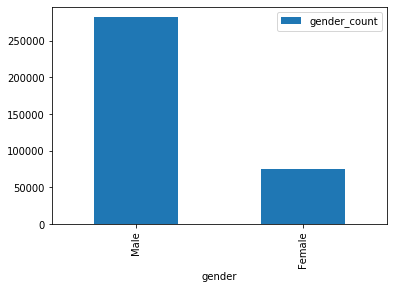

In [0]:
artist_by_gender.plot(kind='bar', x='gender', y='gender_count');

In [0]:
#counts the number of artists affiliated with each area
%%bigquery 
SELECT artist_area As area, COUNT(artist_area) AS area_count
FROM musicbrainz.recordings_by_artists_dataflow_sideinputs
WHERE artist_gender IS NOT NULL 
GROUP BY area
ORDER BY area_count DESC
limit 10

,area,area_count
0,United States,56719
1,United Kingdom,22335
2,Germany,18790
3,Japan,18307
4,France,11963
5,Finland,8750
6,Italy,6641
7,Sweden,6434
8,Spain,6242
9,Canada,5719


In [0]:
%%bigquery artist_by_area
SELECT artist_area As area, COUNT(artist_area) AS area_count
FROM musicbrainz.recordings_by_artists_dataflow_sideinputs
WHERE artist_gender IS NOT NULL 
GROUP BY area
ORDER BY area_count DESC
limit 10

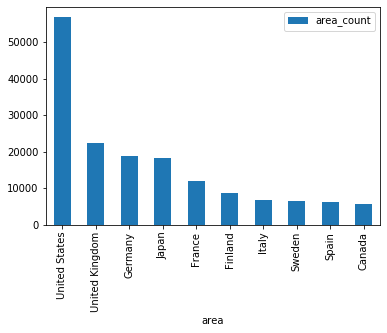

In [0]:
artist_by_area.plot(kind='bar', x='area', y='area_count');

In [0]:
#looking at artist begin date year
%%bigquery 
SELECT artist_name, artist_begin_date_year
FROM musicbrainz.recordings_by_artists_dataflow_sideinputs
WHERE artist_begin_date_year IS NOT NULL
ORDER BY artist_begin_date_year DESC
limit 10;

,artist_name,artist_begin_date_year
0,Gylt,2016
1,The New Enchanters,2016
2,GOMMA,2016
3,SKiNNY MiLK,2016
4,Servants,2016
5,& friends,2016
6,Kevin P. Gilday & The Sea Kings,2016
7,SWEAT,2016
8,Artemus Gordon,2016
9,Mechanical Flowers,2016


In [0]:
%%bigquery artists_begin_year
SELECT artist_begin_date_year AS begin_year, count(artist_begin_date_year) AS artists_count
FROM musicbrainz.recordings_by_artists_dataflow_sideinputs
WHERE artist_begin_date_year IS NOT NULL
GROUP BY begin_year
ORDER BY begin_year DESC
limit 10;

In [0]:
#counting number of artists in each begin year
%%bigquery 
SELECT artist_begin_date_year AS begin_year, count(artist_begin_date_year) AS artists_count
FROM musicbrainz.recordings_by_artists_dataflow_sideinputs
WHERE artist_begin_date_year IS NOT NULL
GROUP BY begin_year
ORDER BY begin_year DESC
limit 10;

,begin_year,artists_count
0,2016,203
1,2015,1073
2,2014,1813
3,2013,2492
4,2012,3137
5,2011,3397
6,2010,3715
7,2009,3541
8,2008,3581
9,2007,3566


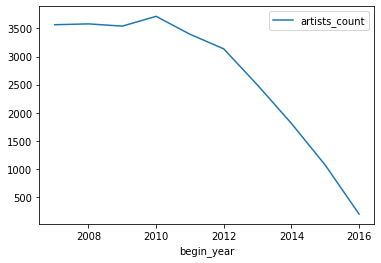

In [0]:
artists_begin_year.plot(x='begin_year');

Optimize the big query schema using nested fields

The current representation of the data is fairly flat. That is, it includes one row per credited recording that includes all the artist's metadata from the BigQuery schema, and all the recording and artist_credit_name metadata. This flat representation has at least two drawbacks:

It repeats the artist metadata for every recording credited to an artist, which in turn increases the storage required.
When you export the data as JSON, it exports an array that repeats that data, instead of an artist with the nested recording data — which is probably what you want.
Without any performance penalty and without using additional storage, instead of storing one recording per row, you can store recordings as a repeated field in each artist record by making some changes to the Dataflow pipeline.

Instead of joining the recordings with their artist information by artist_credit_name.artist, this alternate pipeline creates a nested list of recordings within an artist object.


In [0]:
#Pipeline code
private static List<TableRow> toTableRows(MusicBrainzDataObject mbdo, Map<String, Object> serializableSchema) {
  TableRow row = new TableRow();
  List<TableRow> result = new ArrayList<TableRow>();
  Map<String, List<MusicBrainzDataObject>> nestedLists = new HashMap<String, List<MusicBrainzDataObject>>();
  Set<String> keySet = serializableSchema.keySet();
  /*
   *  construct a row object without the nested objects
   */
  int maxListSize = 0;
  for (String key : keySet) {
    Object value = serializableSchema.get(key);
    Object fieldValue = mbdo.getColumnValue(key);
    if (fieldValue != null) {
      if (value instanceof Map) {
        List<MusicBrainzDataObject> list = (List<MusicBrainzDataObject>) fieldValue;
        if (list.size() > maxListSize) {
          maxListSize = list.size();
        }
        nestedLists.put(key, list);
      } else {
        row.set(key, fieldValue);
      }

    }
  }
  /*
   * add the nested objects but break up the nested objects across duplicate rows if nesting limit exceeded
   */
  TableRow parent = row.clone();
  Set<String> listFields = nestedLists.keySet();
  for (int i = 0; i < maxListSize; i++) {
    parent = (parent == null ? row.clone() : parent);
    final TableRow parentRow = parent;
    nestedLists.forEach((String key, List<MusicBrainzDataObject> nestedList) -> {
      if (nestedList.size() > 0) {
        if (parentRow.get(key) == null) {
          parentRow.set(key, new ArrayList<TableRow>());
        }
        List<TableRow> childRows = (List<TableRow>) parentRow.get(key);
        childRows.add(toChildRow(nestedList.remove(0), (Map<String, Object>) serializableSchema.get(key)));
      }
    });
    if ((i > 0) && (i % BIGQUERY_NESTING_LIMIT == 0)) {
      result.add(parent);
      parent = null;
    }
  }
  if (parent != null) {
    result.add(parent);
  }
  return result;
}

change export destination to a new table

> export DESTINATION_TABLE=recordings_by_artists_dataflow_nested

run the nested version

> ./run.sh nested

In [0]:
#Query complete (1.3 sec elapsed, 2.3 GB processed)
%%bigquery
SELECT artist_name, artist_gender, artist_area, artist_recordings
FROM musicbrainz.recordings_by_artists_dataflow_nested
WHERE artist_area IS NOT NULL
AND artist_gender IS NOT NULL
ORDER BY artist_area DESC
LIMIT 10

,artist_name,artist_gender,artist_area,artist_recordings
0,Muḥammad Shāwīsh,Male,Ḩimş,"[{'artist_credit_name_artist_credit': 1620838,..."
1,Scalameriya,Male,Šumadijski okrug,"[{'artist_credit_name_artist_credit': 1619162,..."
2,Tahir Oturan,Male,Şanlıurfa,[]
3,Valentin Triller,Male,Śląskie,[]
4,Karol Gwóźdź,Male,Śląskie,"[{'artist_credit_name_artist_credit': 1253626,..."
5,中嶋イッキュウ,Female,Ōtsu,"[{'artist_credit_name_artist_credit': 1611045,..."
6,柏森進,Male,Ōta,"[{'artist_credit_name_artist_credit': 1685686,..."
7,加瀬康之,Male,Ōta,"[{'artist_credit_name_artist_credit': 1307813,..."
8,Piotr Musiał,Male,Łódź,"[{'artist_credit_name_artist_credit': 1178586,..."
9,DJ No Frost,Male,İzmir,"[{'artist_credit_name_artist_credit': 1202048,..."


In [0]:
#Query complete (2.5 sec elapsed, 657 MB processed)
%%bigquery
SELECT artist_name,
       ARRAY(SELECT artist_credit_name_name
               FROM UNNEST(recordings_by_artists_dataflow_nested.artist_recordings)) AS artist_credit_name_name,
       ARRAY(SELECT recording_name
               FROM UNNEST(recordings_by_artists_dataflow_nested.artist_recordings)) AS recording_name
    FROM musicbrainz.recordings_by_artists_dataflow_nested,
      UNNEST(recordings_by_artists_dataflow_nested.artist_recordings) AS artist_recordings_struct
WHERE artist_recordings_struct.recording_name LIKE "%Justin%"
LIMIT 1000;

,artist_name,artist_credit_name_name,recording_name
0,Vasili Gavre,[Vasili Gavre],[Do You Have a Girlfriend (Justin Hermosa mix)...
1,Dead Timber,[Dead Timber],[Justins Spin]
2,Grupo Socavón,"[Grupo Socavón, Grupo Socavón, Grupo Socavón]","[Homenaje a Justino, Homenaje a Justino, Homen..."
3,Grupo Socavón,"[Grupo Socavón, Grupo Socavón, Grupo Socavón]","[Homenaje a Justino, Homenaje a Justino, Homen..."
4,Grupo Socavón,"[Grupo Socavón, Grupo Socavón, Grupo Socavón]","[Homenaje a Justino, Homenaje a Justino, Homen..."
...,...,...,...
995,Fatboy Slim,"[Fatboy Slim, Fatboy Slim, Fatboy Slim, Fatboy...","[The Rockafeller Skank, Right Here Right Now, ..."
996,Totally Enormous Extinct Dinosaurs,"[Totally Enormous Extinct Dinosaurs, Totally E...",[Bournemouth (Tomb Crew's South Coast Teenage ...
997,Totally Enormous Extinct Dinosaurs,"[Totally Enormous Extinct Dinosaurs, Totally E...",[Bournemouth (Tomb Crew's South Coast Teenage ...
998,Totally Enormous Extinct Dinosaurs,"[Totally Enormous Extinct Dinosaurs, Totally E...",[Bournemouth (Tomb Crew's South Coast Teenage ...


In [0]:
#Query complete (0.5 sec elapsed, 657 MB processed)
%%bigquery
SELECT artist_name,
       ARRAY(SELECT artist_credit_name_name
               FROM UNNEST(recordings_by_artists_dataflow_nested.artist_recordings)) AS recording_comment,
       ARRAY(SELECT recording_name
               FROM UNNEST(recordings_by_artists_dataflow_nested.artist_recordings)) AS recording_name
    FROM musicbrainz.recordings_by_artists_dataflow_nested,
      UNNEST(recordings_by_artists_dataflow_nested.artist_recordings) AS artist_recordings_struct
WHERE artist_recordings_struct.recording_name LIKE "%Justin%"
LIMIT 10;

,artist_name,recording_comment,recording_name
0,DJ Anal Wart Virus,[DJ Anal Wart Virus],[Justin Con Carni]
1,Maurizio Baiocchi,[Maurizio Baiocchi],[Old Bastard (Justin Imperiale mix)]
2,Lee Jefferies,[Lee Jefferies],[Drop the Dime (feat. Justin Bourne)]
3,Damonkenutz,[Damonkenutz],[Yellowpants (Justin Martin remix)]
4,Harry Chestwig,"[Harry Chestwig, Harry Chestwig, Harry Chestwig]","[Komm, Sei So Lieb (Louie Prima & Justin Fidél..."
5,Stop The Revolution,"[Stop The Revolution, Stop The Revolution, Sto...","[1996, Reason 42, I'd Sell My Grandmother for ..."
6,New York All Stars,"[New York All Stars, New York All Stars, New Y...","[Nap fe yo Sezi, Kalot, Kompa Chale, Kago Komp..."
7,Social Square,"[Social Square, Social Square, Social Square, ...","[Wasted, It vs. You, No One Knows, Walk in You..."
8,Purple Avenue,"[Purple Avenue, Purple Avenue, Purple Avenue, ...","[Nothing Compares 2 U, American Boy (Estelle f..."
9,Elliott the Letter Ostrich,"[Elliott the Letter Ostrich, Elliott the Lette...","[VHS Rewired (Back to the Future, Part 2), Bea..."


In [0]:
#Query complete (1.4 sec elapsed, 4.6 MB processed)
#getting the distinct areas
%%bigquery
SELECT DISTINCT artist_area
FROM musicbrainz.recordings_by_artists_dataflow_nested
WHERE artist_area IS NOT NULL

,artist_area
0,United Kingdom
1,Japan
2,California
3,Germany
4,Seattle
...,...
5261,Wieliczka
5262,Cookeville
5263,Pinelands
5264,Tippecanoe County


In [0]:
%%bigquery
SELECT 
DISTINCT artist_area, COUNT(CASE artist_gender WHEN 'Male' THEN 1 ELSE NULL END) AS male_artists,
COUNT(CASE artist_gender WHEN 'Female' THEN 1 ELSE NULL END) AS female_artists
FROM musicbrainz.recordings_by_artists_dataflow_nested
WHERE artist_area IS NOT NULL
AND artist_gender IS NOT NULL
GROUP BY artist_area
ORDER BY male_artists DESC
limit 10;

,artist_area,male_artists,female_artists
0,United States,46488,10186
1,United Kingdom,18535,3783
2,Germany,15553,3229
3,Japan,10389,7899
4,France,9824,2137
5,Finland,6576,2172
6,Italy,5596,1041
7,Spain,5475,764
8,Sweden,5123,1310
9,Canada,4425,1289


In [0]:
%%bigquery gender_area
SELECT 
DISTINCT artist_area, COUNT(CASE artist_gender WHEN 'Male' THEN 1 ELSE NULL END) AS male_artists,
COUNT(CASE artist_gender WHEN 'Female' THEN 1 ELSE NULL END) AS female_artists
FROM musicbrainz.recordings_by_artists_dataflow_nested
WHERE artist_area IS NOT NULL
AND artist_gender IS NOT NULL
GROUP BY artist_area
ORDER BY male_artists DESC
limit 10;

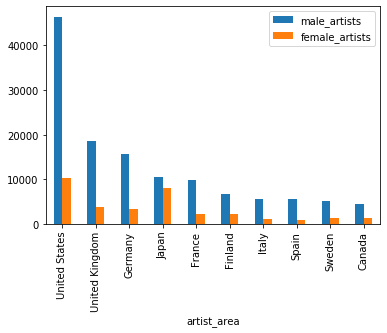

In [0]:
gender_area.plot(kind='bar', x = 'artist_area');

In [0]:
#number of artists identified with each country
%%bigquery 
SELECT 
artist_area, COUNT(DISTINCT artist_name) AS artists_count
FROM musicbrainz.recordings_by_artists_dataflow_nested
WHERE artist_area IS NOT NULL
AND artist_name IS NOT NULL
GROUP BY artist_area
ORDER BY artists_count DESC
limit 10;

,artist_area,artists_count
0,United States,85274
1,United Kingdom,38934
2,Germany,29272
3,Japan,28351
4,France,18867
5,Finland,13384
6,Italy,12077
7,Sweden,11047
8,Canada,9900
9,Spain,9730


In [0]:
#create recordings per area table
#Query complete (2 min 56 sec elapsed, 387.1 MB processed)
%%bigquery area_recording 
SELECT artist_area,
       ARRAY(SELECT recording_name
               FROM UNNEST(recordings_by_artists_dataflow_nested.artist_recordings)) AS recording_name
FROM musicbrainz.recordings_by_artists_dataflow_nested,
      UNNEST(recordings_by_artists_dataflow_nested.artist_recordings) AS artist_recordings_struct
WHERE artist_area IS NOT NULL


In [0]:
#top 10 countries with the highest number of recordings
%%bigquery  
SELECT DISTINCT artist_area, COUNT(recording_name) AS num_recordings
FROM musicbrainz.area_recording
WHERE artist_area IS NOT NULL
AND recording_name IS NOT NULL
GROUP BY artist_area
ORDER BY num_recordings DESC
LIMIT 10;

,artist_area,num_recordings
0,United States,3932542
1,United Kingdom,1857406
2,Germany,986357
3,Japan,705241
4,France,576157
5,Italy,393402
6,Canada,275230
7,Sweden,265638
8,Netherlands,245120
9,Finland,244596


In [0]:
%%bigquery artist_recording_begin 
SELECT artist_name, artist_begin_date_year AS begin_year,
       ARRAY(SELECT recording_name
               FROM UNNEST(recordings_by_artists_dataflow_nested.artist_recordings)) AS recording_name
FROM musicbrainz.recordings_by_artists_dataflow_nested,
      UNNEST(recordings_by_artists_dataflow_nested.artist_recordings) AS artist_recordings_struct
WHERE artist_name IS NOT NULL AND recording_name IS NOT NULL 
AND artist_begin_date_year >= 2000

In [0]:
(Query complete (5.2 sec elapsed, 2 GB processed))
%%bigquery artist_recording
SELECT DISTINCT artist_name, COUNT(recording_name) AS num_recordings
FROM musicbrainz.artist_recording_begin
GROUP BY artist_name

In [0]:
#Query complete (0.3 sec elapsed, 977.5 KB processed)
%%bigquery 
SELECT artist_name, num_recordings
FROM musicbrainz.new
WHERE num_recordings >= 100
ORDER BY num_recordings DESC
LIMIT 10;

,artist_name,num_recordings
0,The Cherry Blues Project,1901
1,初音ミク,1688
2,Two Steps From Hell,1625
3,The Dead,1012
4,Cascada,950
5,TAMUSIC,942
6,Above & Beyond,912
7,The Decemberists,901
8,AKB48,893
9,Glee Cast,886


## IV. HDFS Approach

In this approach, we load the data from the bucket to Hadoop, then we use pyspark sql to read the data in the jupyter notebook and schema is inferred automatically.

Next, we create motif queries using GraphFrames and we run the queries multiple times, changing the number of worker nodes each time; 2, 4, 6, 8, and 10. To increase the number of worker nodes beyond 4 I had to get permissions to increase the quota for CPUs(all regions), Persistent Disk Standard (GB), and In-use IP addresses global .

To increase quota:
>Google Cloud Platform > Navigation menu > IAM & ADMIN > Quotas > Compute Engine API \
CPUs(all regions) > new quota limit:64 \
Persistent Disk Standard (GB) > new quota limit:5500 \
In-use IP addresses global > new quota limit:12



Load the data to Hadoop:

In SSH terminal:
> mkdir musicbrainzdb
cd musicbrainzdb \
gsutil cp gs://mira-bucket/*.json . \
cd .. \
hadoop fs -put musicbrainzdb/ /musicbrainzdb \
mkdir schema
cd schema
gsutil cp gs://mira-bucket/*.json . \                                     
cd .. \
hadoop fs -put schema/ /schema

In [0]:
from pyspark.sql.types import *
from time import time
import sys
import graphframes
from graphframes import *
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [0]:
artist_file = "hdfs:///musicbrainzdb/artist.json"
artist_area_file = "hdfs:///musicbrainzdb/artist_area.json"
artist_gender_file = "hdfs:///musicbrainzdb/artist_gender.json"
recording_file = "hdfs:///musicbrainzdb/recording.json"
artist_credit_name_file = "hdfs:///musicbrainzdb/artist_credit_name.json"
artist_type_file = "hdfs:///musicbrainzdb/artist_type.json"

In [0]:
artist_gender_df = spark.read.json(artist_gender_file) 
recording_df = spark.read.json(recording_file) 
artist_credit_name_df = spark.read.json(artist_credit_name_file) 
artist_type_df = spark.read.json(artist_type_file) 
artist_area_df = spark.read.json(artist_area_file)

In [0]:
artist_schema = StructType([
    StructField("id", IntegerType(), True),    
    StructField("gid", StringType(), True),
    StructField("name", StringType(), True),
    StructField("sort_name", StringType(), True),
    StructField("begin_date_year", IntegerType(), True),
    StructField("begin_date_month", IntegerType(), True),    
    StructField("begin_date_day", IntegerType(), True),
    StructField("end_date_year", IntegerType(), True),
    StructField("end_date_month", IntegerType(), True),
    StructField("end_date_day", IntegerType(), True),
     StructField("type", LongType(), True),    
    StructField("area", IntegerType(), True),
    StructField("gender", IntegerType(), True),
    StructField("comment", StringType(), True),
    StructField("edits_pending", IntegerType(), True),
      StructField("last_updated", TimestampType(), True),
    StructField("ended", BooleanType(), True),
    StructField("begin_area", IntegerType(), True),
    StructField("end_area", IntegerType(), True)
])

In [0]:
artist_df = spark.read.json(artist_file, schema = artist_schema) 

In [0]:
artist_credit_name_df.limit(10).toPandas().head(10)

,artist,artist_credit,join_phrase,name,position
0,578352,578352,,Gustav Ruppke,0
1,273232,273232,,Zachary,0
2,153193,153193,,The High Level Ranters,0
3,32262,32262,,Georges Brassens,0
4,1171184,1389968,,Harvard of the South,0
5,145773,145773,,Aric Leavitt,0
6,1075202,1258383,,Delfino Square,0
7,21361,2125299,",",Bartók,0
8,220155,220155,,Love .45,0
9,847590,2402197,feat.,Protostar,0


In [0]:
artist_df.limit(5).toPandas().head()

,id,gid,name,sort_name,begin_date_year,begin_date_month,begin_date_day,end_date_year,end_date_month,end_date_day,type,area,gender,comment,edits_pending,last_updated,ended,begin_area,end_area
0,805192,8972b1c1-6482-4750-b51f-596d2edea8b1,WIK▲N,WIK▲N,NaN,None,None,NaN,None,None,NaN,NaN,None,,0,2011-05-17 01:31:20.151,False,NaN,None
1,371203,49add228-eac5-4de8-836c-d75cde7369c3,Pete Moutso,"Moutso, Pete",NaN,None,None,NaN,None,None,1.0,NaN,None,,0,NaT,False,NaN,None
2,273232,c112a400-af49-4665-8bba-741531d962a1,Zachary,Zachary,NaN,None,None,NaN,None,None,NaN,NaN,None,,0,NaT,False,NaN,None
3,101060,ca3f3ee1-c4a7-4bac-a16a-0b888a396c6b,The Silhouettes,"Silhouettes, The",1956.0,None,None,1993.0,None,None,2.0,222.0,None,"US doo wop/R&B group ""Get a Job""",0,2014-12-18 05:08:55.749,True,7707.0,None
4,145773,7b4a548e-a01a-49b7-82e7-b49efeb9732c,Aric Leavitt,"Leavitt, Aric",NaN,None,None,NaN,None,None,NaN,NaN,None,,0,NaT,False,NaN,None


In [0]:
recording_df.limit(5).toPandas().head()

,artist_credit,comment,edits_pending,gid,id,last_updated,length,name,video
0,2001233,,0,0f42ab32-22cd-4dcf-927b-a8d9a183d68b,20937085,2017-05-15T20:36:38.082509+00:00,260000,Travelling Man,False
1,2001233,,0,4dce8f93-45ee-4573-8558-8cd321256233,20937086,2017-05-15T20:36:38.082509+00:00,259000,Live Up,False
2,2001233,,0,48fabe3f-0fbd-4145-a917-83d164d6386f,20937087,2017-05-15T20:36:38.082509+00:00,381000,Radiate,False
3,4,,0,b30b9943-9100-4d84-9ad2-69859ea88fbb,11,None,364306,Five Man Army,False
4,2001233,,0,b55f1db3-c6d2-4645-b908-03e1017a99c2,20937088,2017-05-15T20:36:38.082509+00:00,193000,Kalighata (Rain Clouds),False


In [0]:
recording_new = recording_df.selectExpr("name as recording_name", "artist_credit")

In [0]:
recording_new.limit(5).toPandas().head()

,recording_name,artist_credit
0,Travelling Man,2001233
1,Live Up,2001233
2,Radiate,2001233
3,Five Man Army,4
4,Kalighata (Rain Clouds),2001233


In [0]:
artist_credit_name_new = artist_credit_name_df.selectExpr("artist", "artist_credit")
artist_credit_name_new.limit(5).toPandas().head()

,artist,artist_credit
0,578352,578352
1,273232,273232
2,153193,153193
3,32262,32262
4,1171184,1389968


In [0]:
artist_type_df.printSchema()

root
 |-- child_order: long (nullable = true)
 |-- description: string (nullable = true)
 |-- gid: string (nullable = true)
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- parent: long (nullable = true)



In [0]:
artist_type_new = artist_type_df.selectExpr("id as type", "name as artist_type")

In [0]:
artist_type_new.printSchema()

root
 |-- type: long (nullable = true)
 |-- artist_type: string (nullable = true)



In [0]:
artist_area_new = artist_area_df.selectExpr("id as area", "name as artist_area")

In [0]:
artist_area_new.limit(5).toPandas().head()

,area,artist_area
0,15449,Greccio
1,38,Canada
2,43,Chile
3,44,China
4,36,Cambodia


In [0]:
artist_gender_new = artist_gender_df.selectExpr("id as gender", "name as artist_gender")

In [0]:
artist_gender_new.printSchema()

root
 |-- gender: long (nullable = true)
 |-- artist_gender: string (nullable = true)



In [0]:
recording_df.printSchema()

root
 |-- artist_credit: long (nullable = true)
 |-- comment: string (nullable = true)
 |-- edits_pending: long (nullable = true)
 |-- gid: string (nullable = true)
 |-- id: long (nullable = true)
 |-- last_updated: string (nullable = true)
 |-- length: long (nullable = true)
 |-- name: string (nullable = true)
 |-- video: boolean (nullable = true)



In [0]:
artist_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gid: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sort_name: string (nullable = true)
 |-- begin_date_year: integer (nullable = true)
 |-- begin_date_month: integer (nullable = true)
 |-- begin_date_day: integer (nullable = true)
 |-- end_date_year: integer (nullable = true)
 |-- end_date_month: integer (nullable = true)
 |-- end_date_day: integer (nullable = true)
 |-- type: long (nullable = true)
 |-- area: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- comment: string (nullable = true)
 |-- edits_pending: integer (nullable = true)
 |-- last_updated: timestamp (nullable = true)
 |-- ended: boolean (nullable = true)
 |-- begin_area: integer (nullable = true)
 |-- end_area: integer (nullable = true)



Join the dataframes and do the mapping

In [0]:
artist_df.createOrReplaceTempView("artist_df")
artist_type_new.createOrReplaceTempView("artist_type_new")
test = sqlContext.sql("select * FROM artist_df a LEFT JOIN artist_type_new b ON a.type = b.type")

In [0]:
artist_gender_new.createOrReplaceTempView("artist_gender_new")
test.createOrReplaceTempView("test")
test = sqlContext.sql("select * FROM test a LEFT JOIN artist_gender_new b ON a.gender = b.gender")

In [0]:
artist_area_new.createOrReplaceTempView("artist_area_new")
test.createOrReplaceTempView("test")
test = sqlContext.sql("select * FROM test a LEFT JOIN artist_area_new b ON a.area = b.area")

In [0]:
artist_credit_name_new.createOrReplaceTempView("artist_credit_name_new")
recording_new.createOrReplaceTempView("recording_new")
join = sqlContext.sql("select * FROM artist_credit_name_new a INNER JOIN recording_new b ON a.artist_credit = b.artist_credit")

In [0]:
join.limit(5).toPandas().head()

,artist,artist_credit,recording_name,artist_credit
0,26,26,Heavy Scene,26
1,26,26,London,26
2,26,26,Nazi Punks Fuck Off,26
3,26,26,Heavy Scene (radio edit),26
4,26,26,Nutopia (Subgenius mix),26


In [0]:
join.createOrReplaceTempView("join")
test.createOrReplaceTempView("test")
test = sqlContext.sql("select * FROM test a INNER JOIN join b ON a.id = b.artist")

In [0]:
test = test.drop("artist_credit")
test.limit(5).toPandas().head()

,id,gid,name,sort_name,begin_date_year,begin_date_month,begin_date_day,end_date_year,end_date_month,end_date_day,...,edits_pending,last_updated,ended,begin_area,end_area,artist_type,artist_gender,artist_area,artist,recording_name
0,26,f75014c9-4950-4c79-b6e4-56e909ae76f2,Meg Lee Chin,"Chin, Meg Lee",None,None,None,None,None,None,...,0,2019-12-30 00:28:32.588,False,896,None,Person,Female,United Kingdom,26,Nutopia (The Looptopia mix)
1,26,f75014c9-4950-4c79-b6e4-56e909ae76f2,Meg Lee Chin,"Chin, Meg Lee",None,None,None,None,None,None,...,0,2019-12-30 00:28:32.588,False,896,None,Person,Female,United Kingdom,26,Sweet Thing
2,26,f75014c9-4950-4c79-b6e4-56e909ae76f2,Meg Lee Chin,"Chin, Meg Lee",None,None,None,None,None,None,...,0,2019-12-30 00:28:32.588,False,896,None,Person,Female,United Kingdom,26,Thing
3,26,f75014c9-4950-4c79-b6e4-56e909ae76f2,Meg Lee Chin,"Chin, Meg Lee",None,None,None,None,None,None,...,0,2019-12-30 00:28:32.588,False,896,None,Person,Female,United Kingdom,26,Just One Fix
4,26,f75014c9-4950-4c79-b6e4-56e909ae76f2,Meg Lee Chin,"Chin, Meg Lee",None,None,None,None,None,None,...,0,2019-12-30 00:28:32.588,False,896,None,Person,Female,United Kingdom,26,Thing (Critter Fish mix)


In [0]:
test = test.drop("gender","area","type")
test.limit(5).toPandas().head()

,id,gid,name,sort_name,begin_date_year,begin_date_month,begin_date_day,end_date_year,end_date_month,end_date_day,comment,edits_pending,last_updated,ended,begin_area,end_area,artist_type,artist_gender,artist_area
0,805192,8972b1c1-6482-4750-b51f-596d2edea8b1,WIK▲N,WIK▲N,NaN,None,None,NaN,None,None,,0,2011-05-17 01:31:20.151,False,NaN,None,None,None,None
1,371203,49add228-eac5-4de8-836c-d75cde7369c3,Pete Moutso,"Moutso, Pete",NaN,None,None,NaN,None,None,,0,NaT,False,NaN,None,Person,None,None
2,273232,c112a400-af49-4665-8bba-741531d962a1,Zachary,Zachary,NaN,None,None,NaN,None,None,,0,NaT,False,NaN,None,None,None,None
3,101060,ca3f3ee1-c4a7-4bac-a16a-0b888a396c6b,The Silhouettes,"Silhouettes, The",1956.0,None,None,1993.0,None,None,"US doo wop/R&B group ""Get a Job""",0,2014-12-18 05:08:55.749,True,7707.0,None,Group,None,United States
4,145773,7b4a548e-a01a-49b7-82e7-b49efeb9732c,Aric Leavitt,"Leavitt, Aric",NaN,None,None,NaN,None,None,,0,NaT,False,NaN,None,None,None,None


In [0]:
comp_time_list = [0,0,0,0,0]

In [0]:
#getting all male artists
subject_df = test.select("name").distinct()
object_df = test.select("artist_gender").distinct()

vertices = subject_df.union(object_df)
vertices = vertices.withColumnRenamed("name","id").select("id")
edges = test.withColumnRenamed("name","src").withColumnRenamed("artist_gender","dst").select("src","dst")
graph = GraphFrame(vertices,edges)

In [0]:
results = graph.find("(a)-[e]->(b)").filter("b.id='Male'")
results = results.dropDuplicates()
results.withColumnRenamed("a","artist").withColumnRenamed("b","gender").select("artist","gender").sort("artist",ascending = True).show(20,False)
print(results.count())

+--------------------------+------+
|artist                    |gender|
+--------------------------+------+
|[!Mc'Lain!]               |[Male]|
|[!Ved]                    |[Male]|
|[!大(大)大!]                 |[Male]|
|["Alpha Wolf Kodi"]       |[Male]|
|["Baby Face" Leroy Foster]|[Male]|
|["Big" Dave Repace]       |[Male]|
|["Blue Ice" Bragason]     |[Male]|
|["Bubba" Lee Jones]       |[Male]|
|["Buddha" Robert Huffman] |[Male]|
|["Cat Daddy"]             |[Male]|
|["Chester" Cianci]        |[Male]|
|["Curly" Howard Sisk]     |[Male]|
|["DD"]                    |[Male]|
|["Da Don" Tommy Lee]      |[Male]|
|["Deacon" Jim Lawyer]     |[Male]|
|["Doc" Dasher]            |[Male]|
|["Doggy" Sack]            |[Male]|
|["Dubfire" Smith]         |[Male]|
|["E"qual]                 |[Male]|
|["Evil" Jared Hasselhoff] |[Male]|
+--------------------------+------+
only showing top 20 rows

491462


In [0]:
from time import time
start_comp = time()

results = graph.find("(a)-[e]->(b)").filter("b.id='Male'")
results = results.dropDuplicates()
results.withColumnRenamed("a","artist").withColumnRenamed("b","gender").select("artist","gender").sort("artist",ascending = True).show(20,False)

end_comp = time()
comp_time = end_comp - start_comp

# add time to list  
comp_time_list[0] = comp_time

print('\n','-'*40)
print(" Computation time is: {:0.2f} seconds".format(comp_time))

+--------------------------+------+
|artist                    |gender|
+--------------------------+------+
|[!Mc'Lain!]               |[Male]|
|[!Ved]                    |[Male]|
|[!大(大)大!]                 |[Male]|
|["Alpha Wolf Kodi"]       |[Male]|
|["Baby Face" Leroy Foster]|[Male]|
|["Big" Dave Repace]       |[Male]|
|["Blue Ice" Bragason]     |[Male]|
|["Bubba" Lee Jones]       |[Male]|
|["Buddha" Robert Huffman] |[Male]|
|["Cat Daddy"]             |[Male]|
|["Chester" Cianci]        |[Male]|
|["Curly" Howard Sisk]     |[Male]|
|["DD"]                    |[Male]|
|["Da Don" Tommy Lee]      |[Male]|
|["Deacon" Jim Lawyer]     |[Male]|
|["Doc" Dasher]            |[Male]|
|["Doggy" Sack]            |[Male]|
|["Dubfire" Smith]         |[Male]|
|["E"qual]                 |[Male]|
|["Evil" Jared Hasselhoff] |[Male]|
+--------------------------+------+
only showing top 20 rows

('\n', '----------------------------------------')
 Computation time is: 26.66 seconds


In [0]:
#get all male artists who live in the China

df_gender = test.select("name","artist_gender")
df_area = test.select("name","artist_area")
df_all = df_gender.union(df_area)

subject_df = test.select("name").distinct()
object_df1 = test.select("artist_gender").distinct()
object_df2 = test.select("artist_area").distinct()
object_df=object_df1.union(object_df2)

vertices = subject_df.union(object_df)
vertices = vertices.withColumnRenamed("name","id").select("id")
edges = df_all.withColumnRenamed("name","src").withColumnRenamed("artist_gender","dst").select("src","dst")
graph = GraphFrame(vertices,edges)

In [0]:
results = graph.find("(a)-[e]->(b);(a)-[e2]->(c)").filter("b.id='Male' and c.id='China'")
results = results.dropDuplicates()
results.withColumnRenamed("a","artist").withColumnRenamed("c","country").select("artist","country").sort("artist",ascending = True).show(20,False)
print(results.count())

+-----------------+-------+
|artist           |country|
+-----------------+-------+
|[AA-LONG]        |[China]|
|[Adil]           |[China]|
|[Amnjk]          |[China]|
|[Anqin Mei]      |[China]|
|[Atom]           |[China]|
|[B6]             |[China]|
|[BOBO]           |[China]|
|[Baosheng Ning]  |[China]|
|[Berry]          |[China]|
|[Biguang Tang]   |[China]|
|[Brass Face]     |[China]|
|[Bright Sheng]   |[China]|
|[Broken Thoughts]|[China]|
|[Bruce Pak]      |[China]|
|[CORSAK]         |[China]|
|[Ca Zhuxi]       |[China]|
|[Chace]          |[China]|
|[Chan Hon-kwong] |[China]|
|[Chan Wai Fat]   |[China]|
|[Chen Honglin]   |[China]|
+-----------------+-------+
only showing top 20 rows

811


In [0]:
#using 2 node workers
from time import time
start_comp = time()
results = graph.find("(a)-[e]->(b);(a)-[e2]->(c)").filter("b.id='Male' and c.id='China'")
results = results.dropDuplicates()
results.withColumnRenamed("a","artist").withColumnRenamed("c","country").select("artist","country").sort("artist",ascending = True).show(20,False)
print(results.count())
end_comp = time()
comp_time = end_comp - start_comp
comp_time_list[0] = comp_time
print('\n','-'*40)
print(" Computation time is: {:0.2f} seconds".format(comp_time))

+-----------------+-------+
|artist           |country|
+-----------------+-------+
|[AA-LONG]        |[China]|
|[Adil]           |[China]|
|[Amnjk]          |[China]|
|[Anqin Mei]      |[China]|
|[Atom]           |[China]|
|[B6]             |[China]|
|[BOBO]           |[China]|
|[Baosheng Ning]  |[China]|
|[Berry]          |[China]|
|[Biguang Tang]   |[China]|
|[Brass Face]     |[China]|
|[Bright Sheng]   |[China]|
|[Broken Thoughts]|[China]|
|[Bruce Pak]      |[China]|
|[CORSAK]         |[China]|
|[Ca Zhuxi]       |[China]|
|[Chace]          |[China]|
|[Chan Hon-kwong] |[China]|
|[Chan Wai Fat]   |[China]|
|[Chen Honglin]   |[China]|
+-----------------+-------+
only showing top 20 rows

811
('\n', '----------------------------------------')
 Computation time is: 98.89 seconds


In [0]:
#using 4 node workers
from time import time
start_comp = time()
results = graph.find("(a)-[e]->(b);(a)-[e2]->(c)").filter("b.id='Male' and c.id='China'")
results = results.dropDuplicates()
results.withColumnRenamed("a","artist").withColumnRenamed("c","country").select("artist","country").sort("artist",ascending = True).show(20,False)
print(results.count())
end_comp = time()
comp_time = end_comp - start_comp
comp_time_list[1] = comp_time
print('\n','-'*40)
print(" Computation time is: {:0.2f} seconds".format(comp_time))

+-----------------+-------+
|artist           |country|
+-----------------+-------+
|[AA-LONG]        |[China]|
|[Adil]           |[China]|
|[Amnjk]          |[China]|
|[Anqin Mei]      |[China]|
|[Atom]           |[China]|
|[B6]             |[China]|
|[BOBO]           |[China]|
|[Baosheng Ning]  |[China]|
|[Berry]          |[China]|
|[Biguang Tang]   |[China]|
|[Brass Face]     |[China]|
|[Bright Sheng]   |[China]|
|[Broken Thoughts]|[China]|
|[Bruce Pak]      |[China]|
|[CORSAK]         |[China]|
|[Ca Zhuxi]       |[China]|
|[Chace]          |[China]|
|[Chan Hon-kwong] |[China]|
|[Chan Wai Fat]   |[China]|
|[Chen Honglin]   |[China]|
+-----------------+-------+
only showing top 20 rows

811
('\n', '----------------------------------------')
 Computation time is: 83.84 seconds


In [0]:
#using 6 node workers
from time import time
start_comp = time()
results = graph.find("(a)-[e]->(b);(a)-[e2]->(c)").filter("b.id='Male' and c.id='China'")
results = results.dropDuplicates()
results.withColumnRenamed("a","artist").withColumnRenamed("c","country").select("artist","country").sort("artist",ascending = True).show(20,False)
print(results.count())
end_comp = time()
comp_time = end_comp - start_comp
comp_time_list[2] = comp_time
print('\n','-'*40)
print(" Computation time is: {:0.2f} seconds".format(comp_time))

+-----------------+-------+
|artist           |country|
+-----------------+-------+
|[AA-LONG]        |[China]|
|[Adil]           |[China]|
|[Amnjk]          |[China]|
|[Anqin Mei]      |[China]|
|[Atom]           |[China]|
|[B6]             |[China]|
|[BOBO]           |[China]|
|[Baosheng Ning]  |[China]|
|[Berry]          |[China]|
|[Biguang Tang]   |[China]|
|[Brass Face]     |[China]|
|[Bright Sheng]   |[China]|
|[Broken Thoughts]|[China]|
|[Bruce Pak]      |[China]|
|[CORSAK]         |[China]|
|[Ca Zhuxi]       |[China]|
|[Chace]          |[China]|
|[Chan Hon-kwong] |[China]|
|[Chan Wai Fat]   |[China]|
|[Chen Honglin]   |[China]|
+-----------------+-------+
only showing top 20 rows

811
('\n', '----------------------------------------')
 Computation time is: 79.55 seconds


In [0]:
#using 8 node workers
from time import time
start_comp = time()
results = graph.find("(a)-[e]->(b);(a)-[e2]->(c)").filter("b.id='Male' and c.id='China'")
results = results.dropDuplicates()
results.withColumnRenamed("a","artist").withColumnRenamed("c","country").select("artist","country").sort("artist",ascending = True).show(20,False)
print(results.count())
end_comp = time()
comp_time = end_comp - start_comp
comp_time_list[1] = comp_time
print('\n','-'*40)
print(" Computation time is: {:0.2f} seconds".format(comp_time))

+-----------------+-------+
|artist           |country|
+-----------------+-------+
|[AA-LONG]        |[China]|
|[Adil]           |[China]|
|[Amnjk]          |[China]|
|[Anqin Mei]      |[China]|
|[Atom]           |[China]|
|[B6]             |[China]|
|[BOBO]           |[China]|
|[Baosheng Ning]  |[China]|
|[Berry]          |[China]|
|[Biguang Tang]   |[China]|
|[Brass Face]     |[China]|
|[Bright Sheng]   |[China]|
|[Broken Thoughts]|[China]|
|[Bruce Pak]      |[China]|
|[CORSAK]         |[China]|
|[Ca Zhuxi]       |[China]|
|[Chace]          |[China]|
|[Chan Hon-kwong] |[China]|
|[Chan Wai Fat]   |[China]|
|[Chen Honglin]   |[China]|
+-----------------+-------+
only showing top 20 rows

811
('\n', '----------------------------------------')
 Computation time is: 75.66 seconds


In [0]:
#using 10 node workers
from time import time
start_comp = time()
results = graph.find("(a)-[e]->(b);(a)-[e2]->(c)").filter("b.id='Male' and c.id='China'")
results = results.dropDuplicates()
results.withColumnRenamed("a","artist").withColumnRenamed("c","country").select("artist","country").sort("artist",ascending = True).show(20,False)
print(results.count())
end_comp = time()
comp_time = end_comp - start_comp
comp_time_list[3] = comp_time
print('\n','-'*40)
print(" Computation time is: {:0.2f} seconds".format(comp_time))

+-----------------+-------+
|artist           |country|
+-----------------+-------+
|[AA-LONG]        |[China]|
|[Adil]           |[China]|
|[Amnjk]          |[China]|
|[Anqin Mei]      |[China]|
|[Atom]           |[China]|
|[B6]             |[China]|
|[BOBO]           |[China]|
|[Baosheng Ning]  |[China]|
|[Berry]          |[China]|
|[Biguang Tang]   |[China]|
|[Brass Face]     |[China]|
|[Bright Sheng]   |[China]|
|[Broken Thoughts]|[China]|
|[Bruce Pak]      |[China]|
|[CORSAK]         |[China]|
|[Ca Zhuxi]       |[China]|
|[Chace]          |[China]|
|[Chan Hon-kwong] |[China]|
|[Chan Wai Fat]   |[China]|
|[Chen Honglin]   |[China]|
+-----------------+-------+
only showing top 20 rows

811
('\n', '----------------------------------------')
 Computation time is: 73.10 seconds


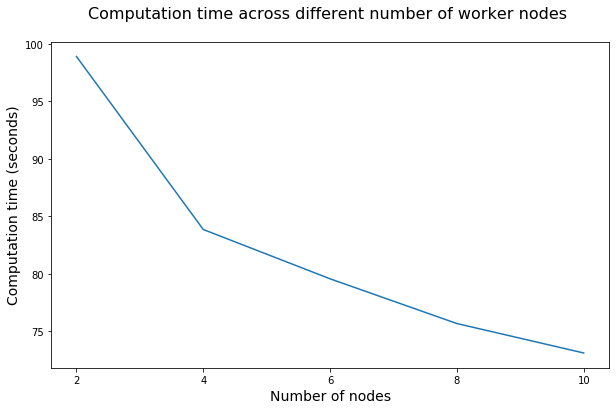

In [0]:
from matplotlib import pyplot as plt
import numpy as np
comp_time_list = [98.89, 83.84, 79.55, 75.66, 73.10]
num_nodes = [2,4,6,8,10]
plt.figure(figsize=(10,6))
plt.plot(num_nodes, comp_time_list)

plt.title("Computation time across different number of worker nodes \n", fontsize=16)

plt.xlabel("Number of nodes", fontsize=14)
plt.xticks(np.arange(2, 11, step=2))
plt.ylabel("Computation time (seconds)", fontsize=14)


plt.show()

In [0]:
#artists with highest number of recordings
subject_df = test.select("name").distinct()
object_df = test.select("recording_name").distinct()

vertices = subject_df.union(object_df)
vertices = vertices.withColumnRenamed("name","id").select("id")
edges = test.withColumnRenamed("name","src").withColumnRenamed("recording_name","dst").select("src","dst")
graph = GraphFrame(vertices,edges)

In [0]:
graph.outDegrees.sort("outDegree", ascending=False).show(10)

+--------------------+---------+
|                  id|outDegree|
+--------------------+---------+
|           [unknown]|   127241|
|         [no artist]|    49071|
|   Bruce Springsteen|    41123|
|       Elvis Presley|    25461|
|         The Beatles|    22550|
|       J. K. Rowling|    22392|
|   The E Street Band|    20715|
|[language instruc...|    20674|
|           Pearl Jam|    20661|
|                  U2|    20154|
+--------------------+---------+
only showing top 10 rows



## References

[1] https://graphframes.github.io/graphframes/docs/_site/index.html
[2] https://github.com/lalinsky/mbdata
